In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from keras.preprocessing.image import load_img, img_to_array

2024-11-22 12:50:16.309840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732254616.423777    1401 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732254616.456087    1401 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 12:50:16.771348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Path ke direktori dataset
train_dir = '../datasets/train_blink_set'
validation_dir = '../datasets/test_blink_set'

In [4]:
# Data augmentation dan preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    brightness_range=[0.8, 1.2],
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 1202 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


In [23]:
# Load MobileNetV3 model
base_model = MobileNetV3Large(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

In [24]:
checkpoint_path = "../model_download/blink/pertama/model_blink.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_path,
                monitor="val_accuracy",
                verbose=1,
                save_best_only=True,
                save_weights_only=False,
                mode="max",
                save_freq="epoch",
            )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [25]:
# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - Precision: 0.7678 - Recall: 0.7607 - accuracy: 0.7414 - loss: 0.6641
Epoch 1: val_accuracy improved from -inf to 0.62847, saving model to ../model_download/blink/pertama/model_blink.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - Precision: 0.7693 - Recall: 0.7624 - accuracy: 0.7436 - loss: 0.6585 - val_Precision: 0.8654 - val_Recall: 0.3103 - val_accuracy: 0.6285 - val_loss: 1.1164
Epoch 2/10
 1/37 ━━━━━━━━━━━━━━━━━━━━ 10s 286ms/step - Precision: 0.7692 - Recall: 0.8333 - accuracy: 0.8438 - loss: 0.2918
Epoch 2: val_accuracy improved from 0.62847 to 0.71429, saving model to ../model_download/blink/pertama/model_blink.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - Precision: 0.7692 - Recall: 0.8333 - accuracy: 0.8438 - loss: 0.2918 - val_Precision: 0.7500 - val_Recall: 0.5000 - val_accuracy: 0.7143 - val_loss: 0.6794
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - Precision: 0.9335 - Recall: 0.9330 - accuracy: 0.9346 - loss: 

In [26]:
# Unfreeze beberapa layers dari base model untuk fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Re-compile model dengan learning rate lebih rendah
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - Precision: 0.9163 - Recall: 0.8490 - accuracy: 0.8886 - loss: 0.2701
Epoch 1: val_accuracy did not improve from 0.71429
37/37 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - Precision: 0.9163 - Recall: 0.8499 - accuracy: 0.8889 - loss: 0.2694 - val_Precision: 0.6757 - val_Recall: 0.7143 - val_accuracy: 0.6944 - val_loss: 0.6588
Epoch 2/10
 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - Precision: 0.9412 - Recall: 0.8421 - accuracy: 0.8750 - loss: 0.2765
Epoch 2: val_accuracy improved from 0.71429 to 0.78571, saving model to ../model_download/blink/pertama/model_blink.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 230ms/step - Precision: 0.9412 - Recall: 0.8421 - accuracy: 0.8750 - loss: 0.2765 - val_Precision: 0.9000 - val_Recall: 0.8182 - val_accuracy: 0.7857 - val_loss: 0.5650
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - Precision: 0.9215 - Recall: 0.9295 - accuracy: 0.9257 - loss: 0.1726
Epoch 3: val_accuracy did not improve from 0.78571
37/37 ━━━━━━

In [27]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(validation_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 441ms/step - Precision: 0.6966 - Recall: 0.7077 - accuracy: 0.6905 - loss: 0.6838
Loss: 0.7160342335700989, Accuracy: 0.6821191906929016, Precision: 0.6666666865348816, Recall: 0.7284768223762512


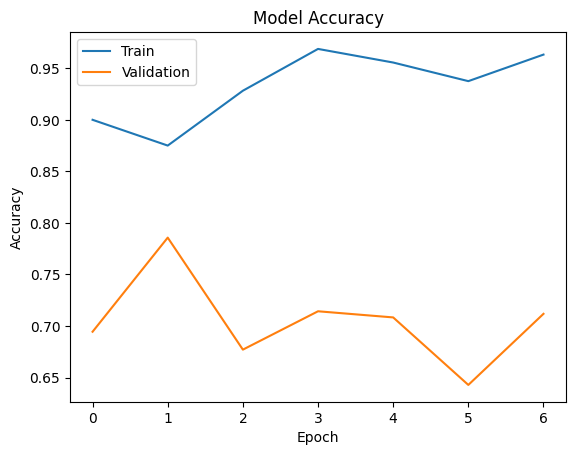

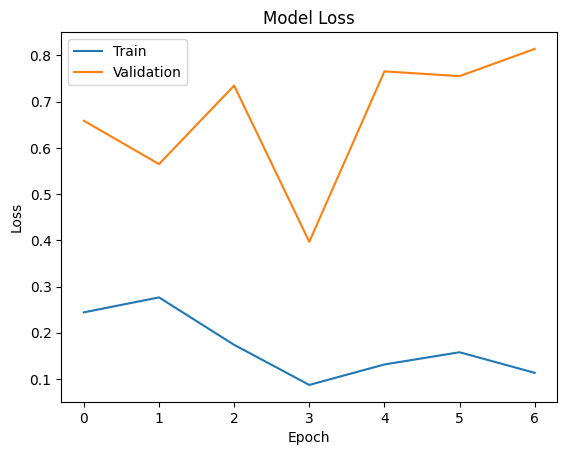

In [28]:
# Plot accuracy dan val_accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss dan val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediction: Closed Eyes
Confidence score: 0.9505


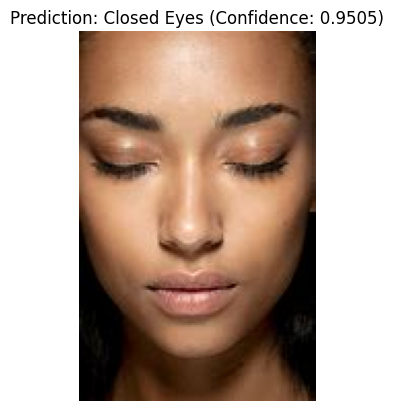

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction: Opened Eyes
Confidence score: 0.9332


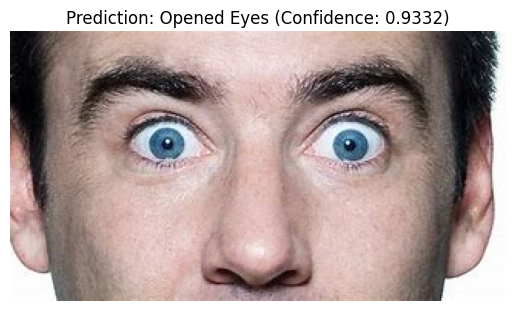

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('../model_download/blink/pertama/model_blink.keras')

# Function to preprocess an image for prediction
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # img_array /= 255.
    return img_array

# Function to predict and display results
def predict_image(image_path):
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)

    if prediction[0][0] > 0.5:
        label = "Opened Eyes"
    else:
        label = "Closed Eyes"

    confidence = prediction[0][0] if label == "Opened Eyes" else 1 - prediction[0][0]

    print(f"Prediction: {label}")
    print(f"Confidence score: {confidence:.4f}")
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(f"Prediction: {label} (Confidence: {confidence:.4f})")
    plt.axis('off')
    plt.show()

test_image_path1 = "../datasets/test/test/closed eyes.jpeg"
test_image_path2 = "../datasets/test/test/opened eyes.jpeg"

predict_image(test_image_path1)
predict_image(test_image_path2)

In [ ]:
import time

# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)
    return img_array

# Fungsi untuk mengukur latensi
def measure_latency(image_path, model, num_runs=100):
    preprocessed_image = preprocess_image(image_path)
    
    for _ in range(10):
        _ = model.predict(preprocessed_image)
    
    start_time = time.time()
    for _ in range(num_runs):
        _ = model.predict(preprocessed_image)
    end_time = time.time()
    
    avg_latency = (end_time - start_time) / num_runs
    print(f"Average latency over {num_runs} runs: {avg_latency:.6f} seconds")

test_image_path = "../datasets/test/test/closed eyes.jpeg"
measure_latency(test_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

In [32]:
# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)
    return img_array

# Mengonversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TFLite ke file
tflite_model_path = '../model_download/blink/pertama/model_blink.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Mengukur latensi model TFLite
def measure_tflite_latency(image_path, tflite_model_path, num_runs=100):
    # Memuat model TFLite
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Mendapatkan ukuran input yang diharapkan
    input_shape = input_details[0]['shape'][1:3]
    
    preprocessed_image = preprocess_image(image_path, target_size=input_shape)
    
    # Warm-up
    for _ in range(10):
        interpreter.set_tensor(input_details[0]['index'], preprocessed_image)
        interpreter.invoke()
    
    # Mengukur latensi
    start_time = time.time()
    for _ in range(num_runs):
        interpreter.set_tensor(input_details[0]['index'], preprocessed_image)
        interpreter.invoke()
    end_time = time.time()
    
    avg_latency = (end_time - start_time) / num_runs
    print(f"Average TFLite latency over {num_runs} runs: {avg_latency:.6f} seconds")

# Contoh penggunaan
test_image_path = "../datasets/test/test/closed eyes.jpeg"
measure_tflite_latency(test_image_path, tflite_model_path)

INFO:tensorflow:Assets written to: /tmp/tmp_oanbvsk/assets


INFO:tensorflow:Assets written to: /tmp/tmp_oanbvsk/assets


Saved artifact at '/tmp/tmp_oanbvsk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139730387310672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139730387354720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139730387357712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139730387318064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139730387318592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139730387360528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139730387361936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139730387365104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139730387364752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139730387364400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13973038736

W0000 00:00:1732256287.757191    1401 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732256287.757286    1401 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-22 13:18:07.757591: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_oanbvsk
2024-11-22 13:18:07.773698: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-22 13:18:07.773862: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp_oanbvsk
2024-11-22 13:18:07.969440: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-22 13:18:08.909524: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp_oanbvsk
2024-11-22 13:18:09.130203: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 1372621 microseconds.


Average TFLite latency over 100 runs: 0.000900 seconds


In [ ]:
# Memuat model Keras
model = tf.keras.models.load_model('../model_download/blink/pertama/model_blink.keras')

# Mengonversi model ke TFLite dengan kuantisasi rentang dinamis
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = converter.convert()

# Menyimpan model TFLite yang telah dikuantisasi ke file
tflite_model_quant_path = '../model_download/blink/model_blink_quant.tflite'
with open(tflite_model_quant_path, 'wb') as f:
    f.write(tflite_model_quant)

print("Model TFLite dengan kuantisasi rentang dinamis telah disimpan.")

INFO:tensorflow:Assets written to: /tmp/tmpk04rz6gw/assets


INFO:tensorflow:Assets written to: /tmp/tmpk04rz6gw/assets


Saved artifact at '/tmp/tmpk04rz6gw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139732482216304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732482227040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732482180192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732482222464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732482224752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732482225984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732482187056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732482190048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732482186704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139732482187408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13973248219

W0000 00:00:1732256317.711102    1401 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732256317.711174    1401 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-22 13:18:37.711393: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpk04rz6gw
2024-11-22 13:18:37.727633: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-22 13:18:37.727759: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpk04rz6gw
2024-11-22 13:18:37.930880: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-22 13:18:38.891880: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpk04rz6gw
2024-11-22 13:18:39.109646: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 1398241 microseconds.


Model TFLite dengan kuantisasi rentang dinamis telah disimpan.


: 